# Decision Trees and Ensemble Learning

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Data Cleaning and Preparation

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv')
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [3]:
df.columns = df.columns.str.lower()

In [4]:
df.status.value_counts()

1    3200
2    1254
0       1
Name: status, dtype: int64

In [5]:
df.status = df.status.map({1:'ok', 2:'default',0:'unk'})

In [6]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,1,60,30,2,1,3,73,129,0,0,800,846
1,ok,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,default,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,ok,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,ok,0,1,36,26,1,1,1,46,107,0,0,310,910


In [7]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [8]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [9]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [10]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [11]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [12]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [13]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [16]:
del df_train['status']
del df_val['status']
del df_test['status']

In [17]:
df_train

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,18,private,36,45,married,no,fixed,45,220.0,20000.0,0.0,800,1600
2668,7,private,60,29,married,no,fixed,60,51.0,3500.0,500.0,1000,1290
2669,1,parents,24,19,single,no,fixed,35,28.0,0.0,0.0,400,600
2670,15,owner,48,43,married,no,freelance,60,100.0,18000.0,0.0,2500,2976


# Decision Trees

In [18]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [19]:
xi = df_train.iloc[0].to_dict()

In [20]:
assess_risk(xi)

'ok'

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [22]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [23]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [24]:
dv.get_feature_names()

['age',
 'amount',
 'assets',
 'debt',
 'expenses',
 'home=ignore',
 'home=other',
 'home=owner',
 'home=parents',
 'home=private',
 'home=rent',
 'home=unk',
 'income',
 'job=fixed',
 'job=freelance',
 'job=others',
 'job=partime',
 'job=unk',
 'marital=divorced',
 'marital=married',
 'marital=separated',
 'marital=single',
 'marital=unk',
 'marital=widow',
 'price',
 'records=no',
 'records=yes',
 'seniority',
 'time']

In [25]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [26]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [27]:
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.6670430602310431

In [28]:
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train, y_pred)

1.0

In [29]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [30]:
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train, y_pred)

0.7761016984958594

In [31]:
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.7389079944782155

In [32]:
from sklearn.tree import export_text

In [33]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



# Decision Tree Learning Algorithm

In [34]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [35]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [36]:
T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
display(df_right)

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


In [37]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [38]:
from IPython.display import display

In [39]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right) 
    print(df_right.status.value_counts(normalize=True))

0


,assets,status
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64
2000


,assets,status
1,2000,default
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64
3000


,assets,status
1,2000,default
2,0,default
7,3000,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


ok         0.8
default    0.2
Name: status, dtype: float64
4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64
5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,status
0,8000,default
6,9000,ok


default    0.5
ok         0.5
Name: status, dtype: float64
8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,status
6,9000,ok


ok    1.0
Name: status, dtype: float64


# Decision Tree Parameter Tuning
- selecting max_depth
- selecting min_samples_leaf

In [40]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d, )
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (d, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.753
  10 -> 0.685
  15 -> 0.656
  20 -> 0.652
None -> 0.654


In [41]:
scores = []

for d in [4,5,6]:
    for s in [1,2,5,10,15,20,100,200,500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d,s,auc))

In [42]:
df_scores = pd.DataFrame(scores, columns=['max_depth','min_samples_leaf','roc_auc'])
df_scores.sort_values(by='roc_auc', ascending=False)[:5]

,max_depth,min_samples_leaf,roc_auc
22,6,15,0.785080
21,6,10,0.778299
24,6,100,0.776434
14,5,20,0.773537
23,6,20,0.773337


In [43]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'],
               values=['roc_auc'])

df_scores_pivot.round(3)

roc_auc              
max_depth              4      5      6
min_samples_leaf                      
1                  0.761  0.767  0.761
2                  0.761  0.767  0.767
5                  0.761  0.768  0.762
10                 0.761  0.762  0.778
15                 0.764  0.773  0.785
20                 0.761  0.774  0.773
100                0.756  0.763  0.776
200                0.747  0.759  0.768
500                0.680  0.680  0.680

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

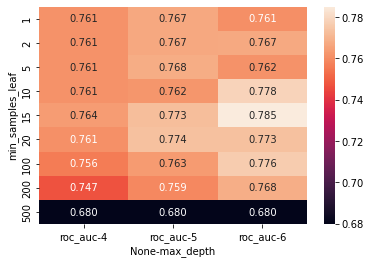

In [44]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [45]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

# Ensemble Learning and Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [48]:
y_pred = rf.predict_proba(X_val)[:,1]

In [49]:
roc_auc_score(y_val, y_pred)

0.7744726453706618

In [50]:
rf.predict_proba(X_val[[0]])

array([[0.9, 0.1]])

In [51]:
scores = []

for n in range(10,201,10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n,auc))

In [52]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

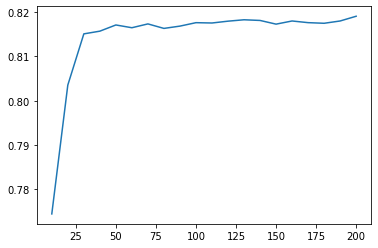

In [53]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [54]:
scores = []

for d in [5, 10, 15]:
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n, 
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d,n,auc))

In [55]:
df_scores = pd.DataFrame(scores, columns=['max_depth','n_estimators', 'auc'])

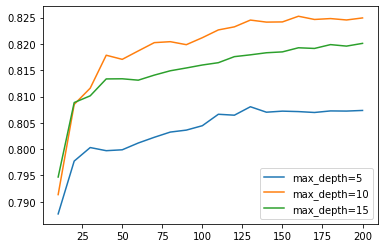

In [56]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth==d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='max_depth=%d' % d)
plt.legend()

In [57]:
max_depth = 10

In [58]:
scores = []

for s in [1,3,5, 10, 50]:
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n, 
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((max_depth,s,n,auc))

In [59]:
df_scores = pd.DataFrame(scores, columns=['max_depth','min_samples_leaf','n_estimators', 'auc'])

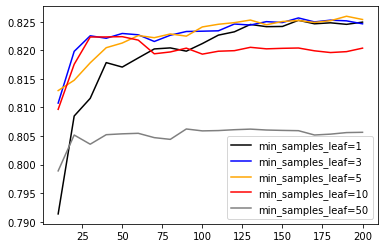

In [60]:
colors = ['black','blue','orange','red','grey']
min_samples_leaf_values = [1,3,5,10,50]

for s, col in zip(min_samples_leaf_values,colors) :
    df_subset = df_scores[df_scores.min_samples_leaf==s]
    plt.plot(df_subset.n_estimators, df_subset.auc, 
             color=col,
             label='min_samples_leaf=%s' % s)
plt.legend()

In [61]:
min_samples_leaf = 3

In [62]:
  rf = RandomForestClassifier(n_estimators=n, 
                                    max_depth=max_depth,
                                    min_samples_leaf=min_samples_leaf,
                                    random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

Another hyperparameter to tune

- max_features
- bootstrap (default=True)
- n_jobs (how many trees can we train in parallel, default=None) --> n_jobs=-1, means use all available processors

In [63]:
rf = RandomForestClassifier(n_estimators=n, 
                                    max_depth=max_depth,
                                    min_samples_leaf=min_samples_leaf,
                                    random_state=1,
                                    n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       n_jobs=-1, random_state=1)

# Gradient Boosting and XGBoost

In [64]:
!pip install xgboost

In [65]:
import xgboost as xgb

In [66]:
features = dv.get_feature_names()

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [67]:
xgb_params = {
    'eta':0.3,
    'max_depth': 6,
    'min_child_weight':1,
    
    'objective':'binary:logistic',
    'nthread':8,
    
    'seed':1,
    'verbosity':1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [68]:
y_pred = model.predict(dval)

In [69]:
roc_auc_score(y_val, y_pred)

0.8003166549611296

In [70]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [71]:
%%capture output

xgb_params = {
    'eta':0.3,
    'max_depth': 6,
    'min_child_weight':1,
    
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'nthread':8,
    
    'seed':1,
    'verbosity':1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  evals=watchlist,
                  verbose_eval=5)

In [72]:
print(output.stdout)

[0]	train-auc:0.86300	val-auc:0.76818
[5]	train-auc:0.92863	val-auc:0.80606
[10]	train-auc:0.95002	val-auc:0.81558
[15]	train-auc:0.96558	val-auc:0.81680
[20]	train-auc:0.97316	val-auc:0.81775
[25]	train-auc:0.98174	val-auc:0.81878
[30]	train-auc:0.98772	val-auc:0.81787
[35]	train-auc:0.99180	val-auc:0.81510
[40]	train-auc:0.99456	val-auc:0.81387
[45]	train-auc:0.99596	val-auc:0.81462
[50]	train-auc:0.99688	val-auc:0.81128
[55]	train-auc:0.99787	val-auc:0.80874
[60]	train-auc:0.99889	val-auc:0.80801
[65]	train-auc:0.99919	val-auc:0.80751
[70]	train-auc:0.99944	val-auc:0.80732
[75]	train-auc:0.99964	val-auc:0.80692
[80]	train-auc:0.99985	val-auc:0.80677
[85]	train-auc:0.99986	val-auc:0.80671
[90]	train-auc:0.99992	val-auc:0.80637
[95]	train-auc:0.99996	val-auc:0.80580
[100]	train-auc:0.99998	val-auc:0.80508
[105]	train-auc:0.99999	val-auc:0.80603
[110]	train-auc:1.00000	val-auc:0.80527
[115]	train-auc:1.00000	val-auc:0.80382
[120]	train-auc:1.00000	val-auc:0.80431
[125]	train-auc:1.0000

In [73]:
s = output.stdout
line = s.split('\n')[0]


In [74]:
num_iter, train_auc, val_auc = line.split('\t')

In [75]:
int(num_iter.strip('[]'))

0

In [76]:
float(train_auc.split(':')[1])

0.863

In [77]:
float(val_auc.split(':')[1])

0.76818

In [78]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [79]:
df_results = parse_xgb_output(output)
df_results.head()

,num_iter,train_auc,val_auc
0,0,0.86300,0.76818
1,5,0.92863,0.80606
2,10,0.95002,0.81558
3,15,0.96558,0.81680
4,20,0.97316,0.81775


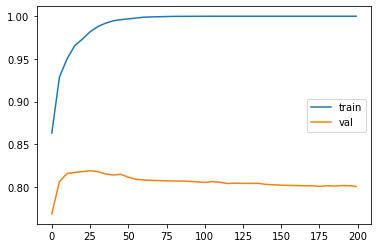

In [80]:
plt.plot(df_results.num_iter, df_results.train_auc, label='train')
plt.plot(df_results.num_iter, df_results.val_auc, label='val')
plt.legend()

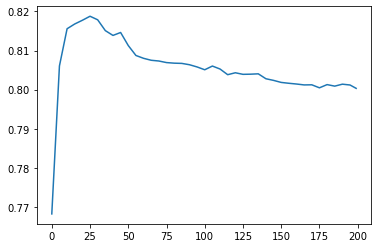

In [81]:
plt.plot(df_results.num_iter, df_results.val_auc, label='val')

# XGBoost Parameter Tuning

In [95]:
scores = {}

In [104]:
%%capture output

xgb_params = {
    'eta':0.05,
    'max_depth': 6,
    'min_child_weight':1,
    
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'nthread':8,
    
    'seed':1,
    'verbosity':1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  evals=watchlist,
                  verbose_eval=5)

In [105]:
key ='eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [106]:
scores.keys()

dict_keys(['eta=0.3', 'eta=1', 'eta=0.1', 'eta=0.01', 'eta=0.05'])

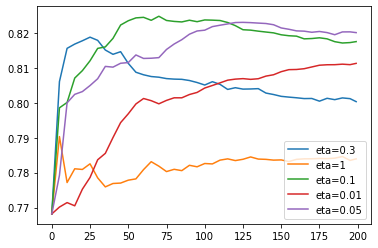

In [107]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()

In [108]:
scores = {}

In [113]:
%%capture output

xgb_params = {
    'eta':0.1,
    'max_depth': 10,
    'min_child_weight':1,
    
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'nthread':8,
    
    'seed':1,
    'verbosity':1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  evals=watchlist,
                  verbose_eval=5)

In [114]:
key ='max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)

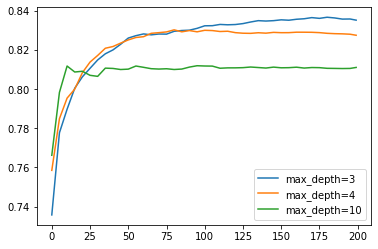

In [115]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()

In [132]:
scores = {}

In [137]:
%%capture output

xgb_params = {
    'eta':0.1,
    'max_depth': 3,
    'min_child_weight':30,
    
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'nthread':8,
    
    'seed':1,
    'verbosity':1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  evals=watchlist,
                  verbose_eval=5)

In [138]:
key ='min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)

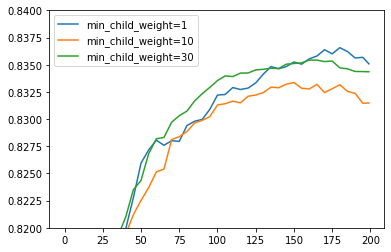

In [140]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
    
plt.ylim(0.82,0.84)
plt.legend()

In [141]:
%%capture output

xgb_params = {
    'eta':0.1,
    'max_depth': 3,
    'min_child_weight':1,
    
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'nthread':8,
    
    'seed':1,
    'verbosity':1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

Useful parameter to tune:
- subsample --> each iteration randomly selecting the train data, how many? 50% ? 25%? etc
- colsample_bytree --> how many features of each tree (0.6, 0.3)
- lambda 
- alpha

# Selecting the Final Model

In [142]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [143]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7852498123077667

In [144]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [145]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [146]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [147]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8360387251459157

In [148]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = (df_full_train.status == 'default').astype(int).values
del df_full_train['status']

In [149]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [150]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names())

In [151]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [153]:
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8322662626460096